# Analyse von Clicklogs einer Suchmaschine

In dieser Übungsaufgabe untersuchen wir einen Ausschnitt von Bing's 26 Monats-Log bis Januar 2020, welcher von [Nick Craswell](https://www.microsoft.com/en-us/research/people/nickcr/) et al. im Juni 2020 mit dem Paper "[ORCAS: 18 Million Clicked Query-Document Pairs for Analyzing Search](https://arxiv.org/pdf/2006.05324.pdf)" veröffentlicht wurde.

Nach einigen einführenden Analysen auf dem Datensatz werden wir zwei der Anwendungsmöglichkeiten "Mining of related Queries" und "Popularity of queries and documents" testen. Den Hauptanwendungsfall derartiger Click-Logs (das trainieren von Ranking-Modellen mit Clicks als Ground-Truth) heben wir fürs erste für spätere Vorlesungen auf :)

Btw.: Ist ein Click-Log mit 18 Millionen Clicks eigentlich "groß"?

# Laden der Daten in ein Dataframe `df`

Laden Sie sich `orcas.tsv.gz` von [microsoft.github.io/TREC-2020-Deep-Learning/ORCAS.html](https://microsoft.github.io/TREC-2020-Deep-Learning/ORCAS.html) herunter und laden Sie es in ein DataFrame `df`.

In [1]:
import pandas as pd

df = pd.read_csv('orcas.tsv.gz', sep='\t', names=['Q_ID', 'Query', 'D_ID', 'D_URL'])

In [59]:
!ls -lha

total 315M
drwxr-xr-x 4 jovyan  1000 4.0K Jul  8 13:22 .
drwsrwsr-x 1 jovyan users 4.0K Jul  8 11:26 ..
drwxr-xr-x 3 jovyan  1000 4.0K Jul  8 11:56 01
drwxr-xr-x 2 jovyan users 4.0K Jul  8 11:36 .ipynb_checkpoints
-r--r--r-- 1 jovyan  1000 315M Jul  8 11:25 orcas.tsv.gz
-rw-r--r-- 1 jovyan  1000 174K Jul  8 13:22 serie-10-aufgabe-05-with-solutions.ipynb


In [60]:
df

,Q_ID,Query,D_ID,D_URL,query_length
0,9265503,github,D1265400,https://desktop.github.com/,1
1,9265503,github,D3438005,https://github.com/,1
2,6832981,youtube,D2923232,https://au.youtube.com/,1
3,9571352,!,D1238374,https://www.englishclub.com/writing/punctuatio...,1
4,9571352,!,D889000,http://nationalpunctuationday.com/exclamationp...,1
...,...,...,...,...,...
18823548,9364218,ð¤¨ meaning,D325990,https://www.merriam-webster.com/dictionary/mea...,2
18823549,10717906,ð¤© meaning,D325990,https://www.merriam-webster.com/dictionary/mea...,2
18823550,10942226,ð¤ª emoji,D74189,http://www.iemoji.com/,2
18823551,11264972,ð¦,D1165065,https://www.lifewire.com/less-obvious-emoji-me...,1


# Vorbereitung

Zuerst verschaffen wir uns einen Überblick über den Datensatz.

## Schritt 1: Wie viele Query-URL Paare gibt es?

In [3]:
len(df)

18823553

## Schritt 2: Wie viele unterschiedliche Queries gibt es?

In [4]:
len(df['Query'].unique())

10404835

## Schritt 3: Wie viele unterschiedliche Dokumente gibt es?

In [5]:
len(df['D_ID'].unique())

1422027

## Schritt 4: Schreiben Sie eine Methode `token_count`.

Die Methode `token_count` soll als eingabe einen String (die Suchanfrage) haben,
und zurückgeben wie viele Wörter die Suchanfrage hat.

Testen Sie ihre Methode anhand folgender Beispiele:
```
assert token_count('youtube') == 1
assert token_count('how zoom works') == 3
assert token_count('where is my refund') == 4
```


In [6]:
def token_count(q):
    return len(str(q).split())

assert token_count('youtube') == 1
assert token_count('how zoom works') == 3
assert token_count('where is my refund') == 4

## Schritt 5: Erweitern sie df um ein Attribut query_length welches den token_count einer Query hat.

In [7]:
df['query_length'] = df['Query'].apply(lambda q: token_count(q))

## Schritt 6: Betrachten Sie ein Paar der kürzesten Suchanfragen und ein Paar der längsten Suchanfragen (in Bezug auf `query_length`)

In [8]:
df.sort_values('query_length', ascending=False).head(10)

,Q_ID,Query,D_ID,D_URL,query_length
25228,5810733,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,D2772262,http://www.answers.com/Q/Find_the_error_its_im...,100
15292770,11210201,the following monthly data are taken from rami...,D206426,https://www.cliffsnotes.com/study-guides/accou...,87
15292771,11210201,the following monthly data are taken from rami...,D312446,https://www.accountingcoach.com/payroll-accoun...,87
15459890,8453634,"three blocks are at rest on a smooth, horizont...",D1893959,https://www.physicsforums.com/threads/contact-...,81
271784,4386101,a sample of an ideal gas goes through the proc...,D3422455,https://answers.yahoo.com/question/index?qid=2...,77
17983786,7840393,which statement about the polynomial function ...,D102431,https://en.wikipedia.org/wiki/Polynomial,75
8462324,9501147,in the game of blackjack played with oneâ deck...,D3178733,https://en.wikipedia.org/wiki/Blackjack,73
17624154,12237281,what is the difference between a price floor a...,D1149800,https://brainly.com/question/2562066,72
8996158,3006433,"jillian is trying to save water, so she reduce...",D3320487,https://brainly.com/question/1377187,72
10092183,5782789,maria is concerned because she has been expose...,D154822,https://brainly.com/question/855809,71


## Schritt 7: Stellen sie die Verteilung von `query_length` zu der Anzahl der Queries dieser Länge geeignet mit Seaborn dar.

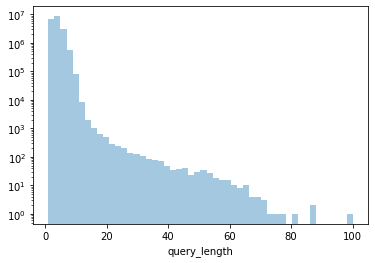

In [16]:
import seaborn as sb

ax = sb.distplot(df['query_length'], kde=False)
ax.set_yscale('log')

# Schritt 8: Erzeugen Sie ein DataFrame `df_nat` welches Natürlichsprachliche Suchanfragen enthält

Suchanfragen sind in der Regel kurz und Keywordbasiert.
(Vergleich: "Facebook" vs "Wo ist die Login-Seite von Facebook?").
Das korrekte extrahieren von natürlichsprachlichen Suchanfragen ist komplex, deswegen verwenden wir eine einfache Heuristik: Wir laden in `df_nat` all die Einträge von `df`, die mit einem der folgenden Wörter beginnen: `['what ', 'how ', 'where ', 'who ', 'is ', 'when ', 'which ', 'can ']`.

In [18]:
df_nat = df[df['Query'].str.startswith(('what ', 'how ', 'where ', 'who ', 'is ', 'when ', 'which ', 'can '), na=False)]

## Schritt 9: Wiederholen Sie Schritt 7 mit `df_nat`


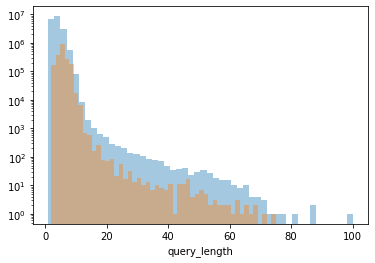

In [20]:
ax1 = sb.distplot(df['query_length'], kde=False)
ax1.set_yscale('log')

ax = sb.distplot(df_nat['query_length'], kde=False)
ax.set_yscale('log')

# Anwendung 1: Identifizieren von verwandten Suchanfragen

Die Click-Beziehung in dem ORCAS-Datensatz formt implizit einen bipartiten Graph zwischen Queries und Dokumenten. Für eine gegebene Suchanfrage besteht eine einfache Möglichkeit zur Identifizierung von verwandten Suchanfragen darin, alle Queries die über zwei Hops von der Ausgangsquery erreichbar sind als verwandt zurückzugeben.

##  Schritt 10: Implementierung von `related_queries` Methode


Implementieren Sie eine methode `related_queries`, welche für eine Suchanfrage `q` als Eingabe alle Suchanfragen zurückgibt, die für ein Dokument geklickt wurden, welches auch für `q` geklickt wurde.

In [21]:
def related_queries(q):
    documents = df.loc[df['Query'] == q]['D_ID']
    
    filter_documents = df['D_ID'].isin(documents)
    
    return sorted(df[filter_documents]['Query'].unique())

## Schritt 11: Testen Sie die `related_queries` Methode

Überlegen Sie sich einige Suchanfragen, für die Sie Ihre `related_queries` Methode testen. Sind die Vorschläge sinnvoll?

In [22]:
related_queries('python')

[' in python',
 ' python',
 '! in python',
 '!= in python',
 '!= meaning in python',
 '!= python',
 '" in python\tD2006453\thttps://www.python.org/\r\n5621848\t" in python',
 '# in python',
 '$ python3',
 '% in python',
 '% operator python',
 '% python',
 '%g python',
 '%i in python',
 '%python',
 '%s python',
 '& in python',
 '& python',
 '&& in python',
 '&& python',
 "' in python",
 '* python',
 '**',
 '** in python',
 '** python',
 '*= in python',
 '*= python',
 '++ in python',
 '++ python',
 '+= in python',
 '+= python',
 '+gethub',
 '+github',
 '+python3',
 '+www.github.com',
 '-= python',
 '-> in python',
 '... in python',
 '... python',
 '.... 3',
 '.any python',
 '.any() python',
 '.append() python',
 '.get python',
 '.github',
 '.github.com/',
 '.github.io',
 '.items python',
 '.map python',
 '.python',
 '.python.org',
 '.sum() python',
 '/ python',
 '// in python',
 '// meaning in python',
 '// python',
 '//= python',
 '//www.python.org/',
 '/= python',
 '/www.python.org',
 

In [23]:
related_queries('pandas')

['.loc pandas',
 '.loc python',
 '100 interesting facts about pandas',
 '20 facts about pandas',
 '3 pandas',
 'a group of pandas',
 'a panda',
 "a panda's habitat",
 'a value is trying to be set on a copy of a slice from a dataframe',
 'about panda',
 'about pandas',
 'add column to dataframe python',
 'adult pandas',
 'ailuropoda melanoleuca',
 'all about giant pandas',
 'all about panda',
 'all about pandas',
 'all about pandas facts',
 'amazing facts about pandas',
 'apnda',
 'append dataframe',
 'append dataframes python',
 'are giant pandas endangered',
 'are pandas aggressive',
 'are pandas bears',
 'are pandas bears really bears',
 'are pandas bears?',
 'are pandas endangered',
 'are pandas endangered 2018',
 'are pandas endangered animals',
 'are pandas omnivores',
 'are pandas really bears',
 'are there pandas in japan',
 'baby panda',
 'baby panda facts',
 'bear panda',
 'big panda',
 'black and white panda',
 'boolean indexing',
 'can pandas be cured',
 'china panda',
 'chi

In [24]:
related_queries('pandas dataframe')

['add column to dataframe python',
 'append dataframe',
 'append dataframes python',
 'convert array to dataframe python',
 'convert dictionary to dataframe',
 'convert series to dataframe',
 'create a dataframe in python',
 'create a dataframe python',
 'create data frame pandas',
 'create dataframe',
 'create dataframe from series',
 'create dataframe in python',
 'create dataframe pandas',
 'create dataframe python',
 'create empty dataframe pandas',
 'create empty dataframe python',
 'create new dataframe pandas',
 'create pandas dataframe',
 'creating pandas dataframe',
 'data frame in python',
 'data frame pandas',
 'data frame python',
 'data frames in python',
 'dataframe',
 'dataframe append',
 'dataframe creation in python',
 'dataframe iloc',
 'dataframe in python',
 'dataframe pandas',
 'dataframe pandas python',
 'dataframe python',
 'dataframe rank',
 'dataframe to list python',
 'dataframe.corr',
 'dataframe.values',
 'dataframes',
 'dataframes in python',
 'dataframes p

In [25]:
related_queries('maik')

['#daily mail',
 "' gmail",
 "'gmail com",
 "'gmail.com",
 "'http://gmail.com/",
 "'http://www.gmail.com/",
 '* gmail',
 '*://mail.google.com/mail/ca*',
 '+daily',
 '+daily mail',
 '+emai',
 '+g mail',
 '+geogle',
 '+gimail',
 '+gmai',
 '+gmai login',
 '+gmail',
 '+gmail .com',
 '+gmail com',
 '+gmail.co.uk',
 '+gmail.com',
 '+gmail.com inbox',
 '+gmail2',
 '+gmailogin',
 '+gmial',
 '+google gmail.com',
 '+googlemail',
 '+googlr',
 '+mail',
 '+www.email.com',
 '+www.gmail.com',
 '+www.gmail.com login',
 '+www.webmail.com',
 ',ail',
 ',ail online',
 ',ailonline',
 ',mail',
 '-gmail',
 '.ail.com',
 '.co.in.co.in.comwww',
 '.co.in.comwww',
 '.com',
 '.com email',
 '.com email address',
 '.com.',
 '.com.com.com.com..com.com.com',
 '.comgmail',
 '.comgmail login',
 '.comgmail,',
 '.comgmail.com/',
 '.comhttps://mail.google.com/mail/u/0/#inbox',
 '.commail',
 '.comwww.gmail',
 '.comwww.www.p',
 '.daily mail',
 '.daily mail online',
 '.daily mail uk',
 '.gamil.com',
 '.gmail',
 '.gmail login'

In [26]:
related_queries('felix')

['feilx',
 'felix',
 'felix meaning',
 'felix name',
 'felix name meaning',
 'felix name origin',
 'felixo',
 'fÃ©lix',
 'meaning of felix',
 'meaning of name felix',
 'meaning of the name felix',
 'name felix',
 'what does felix mean']

In [33]:
df_query_popularity = df[['Q_ID', 'Query', 'D_ID']].groupby(by=['Q_ID', 'Query']).count().rename(columns = {'D_ID':'count'}).sort_values('count').reset_index()

# Anwendung 2: Popularität von Suchanfragen und von Dokumenten

Aufgrund der Vorverarbeitung des ORCAS-Datensatzes (notwendig um nicht zu viel "Business-Value" herauszugeben oder die Privatsphäre der Nutzer zu stark zu gefährden) lassen sich die Popularität von Suchanfragen oder von Dokumenten nicht mehr direkt bestimmen.

Als ersatz schlägt Craswell et al. vor, die Beliebtheit der Dokumente durch die Anzahl der Queries zu messen, für die das Dokument geklickt wurde (denn ein Dokument welches für viele Suchanfragen relevant ist, also geklickt wurde, ist tendentiell populärer als ein Dokument welches welches für weniger Suchanfragen geklickt wurde).

Analog soll die Anzahl der Dokumente die von einer Query aus geklickt wurden die Popularität der Suchanfrage darstellen.

## Schritt 12: Erzeugen Sie `df_document_popularity` welches einem Dokument (`did` sowie `url`) seine Popularität (#Queries für die dieses Dokument geklickt wurde) zuordnet.

Was sind die "beliebtesten" Dokumente?

(Es gibt viel Raum zur Beantwortung zusätzlicher Fragestellungen, wie z.B.: welche Domain ist in dem Datensatz am beliebtesten? Gerne können Sie sich selbst einige Fragestellungen überlegen und beantworten)

In [28]:
df_document_popularity = df[['D_ID', 'D_URL', 'Q_ID']].groupby(by=['D_ID', 'D_URL']).count().rename(columns = {'Q_ID':'count'}).sort_values('count', ascending=False).reset_index()

In [29]:
df_document_popularity

,D_ID,D_URL,count
0,D1049226,https://www.outlook.com/,11310
1,D797874,https://www.whatsapp.com/download/,8382
2,D379730,https://overview.mail.yahoo.com/,6405
3,D627688,https://www.speedtest.net/,6292
4,D1036859,https://signup.live.com/,6249
...,...,...,...
1422022,D1811753,https://www.facebook.com/Belk-163580617003823/,1
1422023,D3154778,http://www.nytimes.com/2013/03/03/realestate/b...,1
1422024,D1811759,http://acronyms.thefreedictionary.com/Seid,1
1422025,D447746,http://www2.smartcu.org/Personal/Help/OnlineBa...,1


## Schritt 13: Erzeugen Sie `df_query_popularity` welches einer Suchanfrage (`qid` sowie `query`) seine Popularität (#Dokumente die für diese Query geklickt wurde) zuordnet.

Was sind die "beliebtesten" Queries?

(Es gibt viel Raum zur Beantwortung zusätzlicher Fragestellungen, wie z.B.: welches Programmiersprache die ich beherrsche ist in dem Datensatz am beliebtesten? Gerne können Sie sich selbst einige Fragestellungen überlegen und beantworten)

In [34]:
df_query_popularity = df[['Q_ID', 'Query', 'D_ID']].groupby(by=['Q_ID', 'Query']).count().rename(columns = {'D_ID':'count'}).sort_values('count', ascending=False).reset_index()
df_query_popularity

,Q_ID,Query,count
0,2000000,it support model,1
1,8373520,common sunflower,1
2,8373519,by accident meaning,1
3,8373518,chocolate chip cookis,1
4,8373516,"central city, colorado",1
...,...,...,...
10405329,7225759,accuweather,938
10405330,12415025,weather channel,1182
10405331,8552816,weather forecast,1239
10405332,11645906,mapquest,1412


## Schritt 14: Implementieren Sie eine `related_queries_popularity` Methode, welche die Queries, die von `related_queries` erzeugt wird nach der Popularität in `df_query_popularity` sortiert

Die Methode `related_queries_popularity` ist als eine Beispielanwendung von `df_query_popularity` gedacht. Verwenden  Sie Ihre Test-Queries aus Schritt 11 erneut: Liefert `related_queries_popularity` ein besseres Ranking der Vorschläge?

In [43]:
def related_queries_popularity(q):
    qs = related_queries(q)

    filter_documents = df_query_popularity['Query'].isin(qs)
    
    return df_query_popularity[filter_documents][['Query', 'count']].sort_values('count', ascending=False)

In [53]:
related_queries_popularity('nullpointer')

,Query,count
6419384,null pointer in c,2
7975029,c++ null pointer,2
8049225,null point,2
8194540,null pointer,2
1080116,what is a null pointer,1
2343125,nullpointer,1
2531119,c null pointer,1
5035012,null dereference,1


In [57]:
related_queries_popularity('conference')

,Query,count
10104259,conference,6
10033814,conference definition,5
9928169,definition of conference,5
9520411,conference meeting,4
9510405,what is conference,4
9471716,what is a conference,4
9177674,what are conferences,3
8853065,confÃ©rence,3
8778102,conference meaning,3
8039929,conferences definition,2


In [44]:
related_queries_popularity('java map')

,Query,count
10098803,hash table,6
9838914,hashtable,4
9807430,hashmap,4
9457447,java list,3
9362407,hashset java,3
...,...,...
2319900,hashmap.get,1
2267204,java hash map,1
2219419,java hashmap put,1
1984994,hashmap put,1


,Query,count
10082034,nullpointerexception,5
10023093,null pointer exception in java,5
10021642,java.lang.nullpointerexception,5
9974730,null pointer exception,5
9845676,nullpointerexception java,4
9823387,java null pointer exception,4
9598885,"exception in thread ""main"" java.lang.nullpoint...",4
8874938,http://java.lang.nullpointerexception/,3
8643857,java.lang.nullpointerexception: null,3
8668773,error java.lang.nullpointerexception,3
